# Tomography of quantum teleportation on logical qubits

This notebook studies the logical errors introduced by a quantum teleportation circuit, when the circuit in run on an emulator of Alice & Bob's logical qubits.

A logical qubit is the combination of multiple physical cat qubits into a more robust qubit using a linear repetition error correction code.
The emulator of logical qubits is configured to match the assumptions of the paper "[Performance Analysis of a Repetition Cat Code Architecture: Computing 256-bit Elliptic Curve Logarithm in 9 Hours with 126133 Cat Qubits](https://arxiv.org/abs/2302.06639)" [Gouzien et al., 2023]. It does not represent the current performance of Alice & Bob's cat qubits.

## Instantiating the emulator

In [14]:
from qiskit_alice_bob_provider import AliceBobLocalProvider
from qiskit import transpile, QuantumCircuit
import numpy as np
from tqdm.notebook import tqdm
from matplotlib import pyplot as plt

In [15]:
provider = AliceBobLocalProvider()
print(provider.backends())

[<ProcessorSimulator(name=EMU:6Q:PHYSICAL_CATS)>, <ProcessorSimulator(name=EMU:40Q:PHYSICAL_CATS)>, <ProcessorSimulator(name=EMU:40Q:LOGICAL_TARGET)>, <ProcessorSimulator(name=EMU:15Q:LOGICAL_EARLY)>, <ProcessorSimulator(name=EMU:1Q:LESCANNE_2020)>]


In [16]:
backend = provider.get_backend('EMU:15Q:LOGICAL_EARLY')

## Quantum teleportation routine

The code below builds a quantum teleportation routine.
After an execution of this circuit, the quantum state of qubit $q_0$ is moved into qubit $q_2$.

In [17]:
def build_teleportation_routine() -> QuantumCircuit:
    teleportation = QuantumCircuit(3, 2, name='teleport')
    teleportation.initialize('+', [1])
    teleportation.initialize('0', [2])
    teleportation.cx(1, 2)
    teleportation.cx(0, 1)
    teleportation.measure_x(0, 0)
    teleportation.measure(1, 1)
    teleportation.x(2).c_if(1, 1)
    teleportation.z(2).c_if(0, 1)
    return teleportation

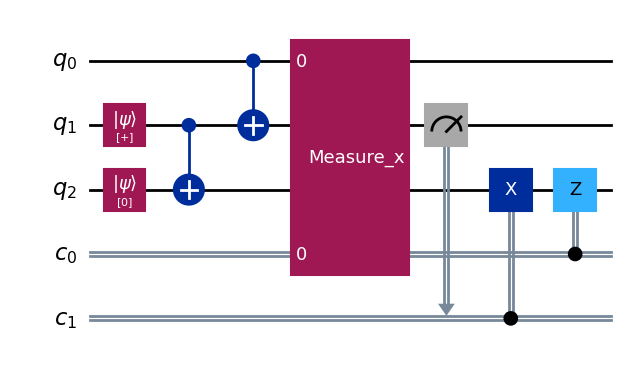

In [18]:
build_teleportation_routine().draw('mpl', cregbundle=False)

## Tomography circuit

The next cells build a circuit that performs a partial quantum process tomography of the teleportation routine discussed above.

It does the following:
* Prepare a known state ($|0>$ or $|+>$) in qubit $q_0$
* Apply the quantum teleportation routine
* Measure the output in qubit $q_2$.
  * If $|0>$ was prepared, a measurement in the Z basis is performed. This will tell us about the (logical) bit flip rate
  * If $|+>$ was prepared, a measurement in the X basis is performed. This will tell us about the (logical) phase flip rate

In [19]:
def build_teleportation_tomography(teleported_state: str) -> QuantumCircuit:
    assert teleported_state in {"+", "-", "0", "1"}
    circuit = QuantumCircuit(3, 3)
    circuit.initialize(teleported_state, 0)
    circuit.append(build_teleportation_routine().to_instruction(), [0, 1, 2], [0, 1])
    if teleported_state in {"+", "-"}:
        circuit.measure_x(2, 2)
    else:
        circuit.measure(2, 2)
    return circuit

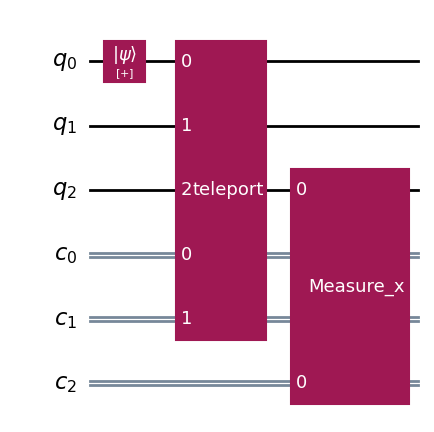

In [20]:
plus_circuit = build_teleportation_tomography('+')
plus_circuit.draw('mpl', cregbundle=False)

Let's transpile this circuit to see how it will be executed on the logical qubits emulator:

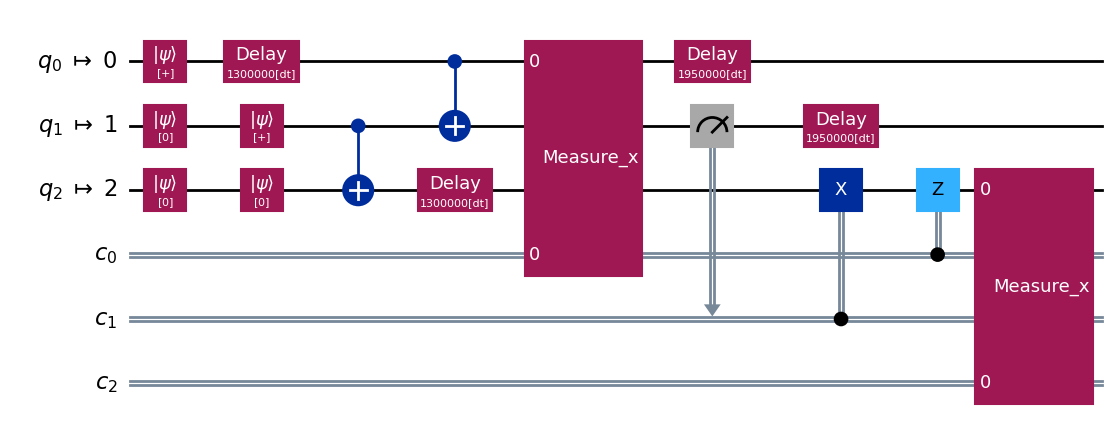

In [21]:
transpiled_plus = transpile(plus_circuit, backend)
transpiled_plus.draw('mpl', cregbundle=False)

An execution on the emulator shows that qubit $q_2$ (the leftmost digit) is almost always in state 0, which we expect. There are however some error due to phase flip errors.

In [22]:
backend.run(transpiled_plus).result().get_counts()

{'101': 5,
 '100': 6,
 '001': 252,
 '110': 2,
 '000': 248,
 '010': 244,
 '111': 1,
 '011': 266}

Let's run an instance of the circuit with a preparation of state $|0>$ to observe bit flips:

In [23]:
zero_circuit = build_teleportation_tomography('0')
transpiled_zero = transpile(zero_circuit, backend)
backend.run(transpiled_zero).result().get_counts()

{'011': 256, '111': 2, '100': 1, '110': 2, '001': 246, '010': 269, '000': 248}

## Quantitative study

In this section, we will execute the quantum teleportation tomography with different sets of parameters for the logical qubits emulation.

The varying parameters study are:
* the average number of photons. The more photons the less bit flips (exponentially) and the more phase flips (linearly).
* the distance of the phase error correction code. A long distance will introduce more bit flips, but also correct phase flips. This is true up to a certain point: if the phase flip error is too high, error correction will only make things worse. We say the phase flip rate is above the error correction threshold.

In [24]:
k1 = 100
k2 = 100_000
average_nb_photonss = np.linspace(4, 24, 11)
distances = 2 * np.arange(1, 10) + 1
shots = 10_000

bit_flips = np.zeros((max(average_nb_photonss.shape), max(distances.shape)))
phase_flips = np.zeros((max(average_nb_photonss.shape), max(distances.shape)))

plus_circuit = build_teleportation_tomography("+")
zero_circuit = build_teleportation_tomography("0")

for j, distance in enumerate(tqdm(distances)):
    for i, average_nb_photons in enumerate(tqdm(average_nb_photonss)):
        backend = provider.get_backend(
            "EMU:40Q:LOGICAL_TARGET",
            average_nb_photons=average_nb_photons,
            distance=distance,
            kappa_2=k2,
            kappa_1=k1,
        )
        counts = backend.run(transpiled_zero, shots=shots).result().get_counts()
        for word, count in counts.items():
            if word[0] == "1":
                bit_flips[i][j] += count
        counts = backend.run(transpiled_plus, shots=shots).result().get_counts()
        for word, count in counts.items():
            if word[0] == "1":
                phase_flips[i][j] += count

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

The bit flip rate is exponentially reduced when increasing the average number of photons. Although a high error correction distance has an adverse effect on the bit flip rate, this effect is quickly anihilated when increasing the average number of photons.

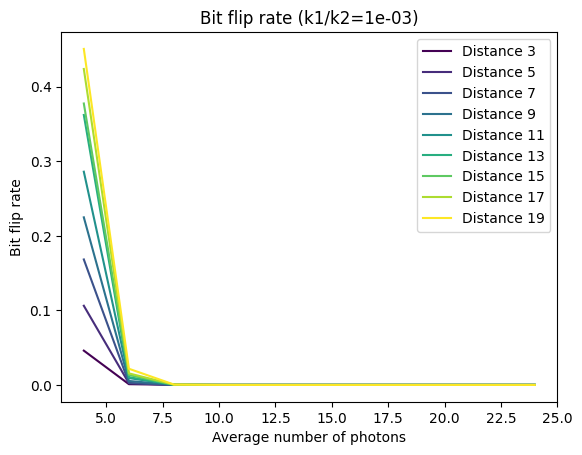

In [25]:
plt.figure()
plt.title(f"Bit flip rate (k1/k2={k1/k2:.0e})")
colors = plt.cm.viridis(np.linspace(0, 1, max(distances.shape)))
for j, distance in enumerate(distances):
    plt.plot(
        average_nb_photonss,
        bit_flips[:, j] / shots,
        label=f"Distance {distance}",
        c=colors[j],
    )
plt.xlabel("Average number of photons")
plt.ylabel("Bit flip rate")
plt.legend()
plt.show()

The phase flip rate generally increases with the average number of photons. This is mitigated by error correction, up to a certain point.
When the average number of photons is high and the phase flip rate is above the error correction threshold, more error correction (larger distance) only makes things worse.

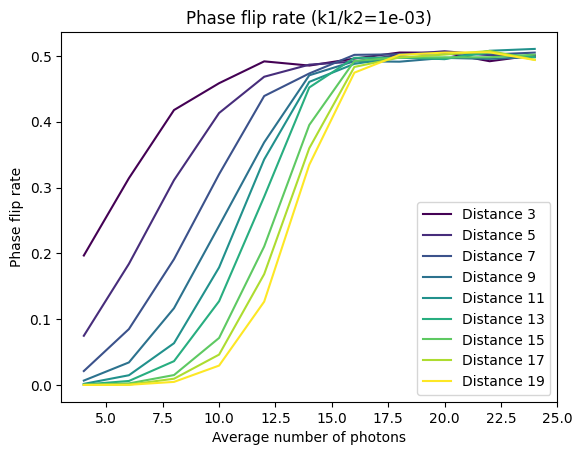

In [26]:
plt.figure()
plt.title(f"Phase flip rate (k1/k2={k1/k2:.0e})")
colors = plt.cm.viridis(np.linspace(0, 1, max(distances.shape)))
for j, distance in enumerate(distances):
    plt.plot(
        average_nb_photonss,
        phase_flips[:, j] / shots,
        label=f"Distance {distance}",
        c=colors[j],
    )
plt.xlabel("Average number of photons")
plt.ylabel("Phase flip rate")
plt.legend()
plt.show()